In [1]:
"""
Learning to solve parametric Quadratic Programming
portfolio optimization
problems using Neuromancer.

Problem formulation:
    minimize    - p^T x + lambda x^T Q x
    subject to       1^T x = 1
                      x >= 0

Where p is interpreted as a vector of asset returns, and Q represents
the covariance between assets, which forms a penalty on overall
covariance (risk) weighted by lambda.
"""

'\nLearning to solve parametric Quadratic Programming\nportfolio optimization\nproblems using Neuromancer.\n\nProblem formulation:\n    minimize    - p^T x + lambda x^T Q x\n    subject to       1^T x = 1\n                      x >= 0\n\nWhere p is interpreted as a vector of asset returns, and Q represents\nthe covariance between assets, which forms a penalty on overall\ncovariance (risk) weighted by lambda.\n'

In [2]:

import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from portfolio_utils import gen_portfolio_lto_data, cvx_qp
import cvxpy as cp
from cvxpylayers.torch.cvxpylayer import CvxpyLayer


In [3]:

""
"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
batsize = 100
n_dim = 20
n_train = 300
n_valid = 100
n_test = 100


# create dictionaries with sampled datapoints with uniform distribution
#data_loaded = np.load('portfolio_data/portfolio_var50_ineq50_eq1_ex12000.npz', allow_pickle=True)
data_loaded = gen_portfolio_lto_data(n_dim,n_train,n_valid,n_test)
Q_load = data_loaded['Q']
A_load = data_loaded['A']
G_load = data_loaded['G']
h_load = data_loaded['h']
x_load = data_loaded['x']
p_train = data_loaded['trainX']
p_valid = data_loaded['validX']
p_test  = data_loaded['testX']
sols_train = data_loaded['trainY']
sols_valid = data_loaded['validY']
sols_test  = data_loaded['testY']
#feat_size_load = data_loaded['feat_size']

print("p_train.dtype")
print( p_train.dtype )

samples_train = {"p": torch.Tensor(p_train)}  # JK TODO fix this, reduced size for debugging
samples_dev   = {"p": torch.Tensor(p_valid)}
samples_test  = {"p": torch.Tensor(p_test )}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data   = DictDataset(samples_dev,   name='dev')
test_data  = DictDataset(samples_test,  name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batsize, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader   = torch.utils.data.DataLoader(dev_data, batch_size=batsize, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batsize, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle


""

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=n_dim, outsize=n_dim,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[n_dim*2] * 4)
# define symbolic solution map with concatenated features (problem parameters)
#xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
#features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['p'], ['x'], name='map')
# trainable components of the problem solution
components = [sol_map]




"""
# # # objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")

# sampled parameters
p = variable('p')
Q = torch.Tensor(Q_load)

# objective function
lambd = 1.0
f = torch.sum(-p*x, dim = 1) + torch.sum( x*torch.matmul(Q,x.T).T, dim=1 ) #-p@x + lambd * x@Q@x
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
e = torch.ones(n_dim)
Q_con = 100.
con_1 = Q_con*(torch.sum(x, dim=1) == 1) #Q_con*(e@x == 1)
con_1.name = 'c1'
con_2 = Q_con * (x >= 0)
con_2.name = 'c2'

constraints = [con_1, con_2]






"""
# # #  problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)


"""
# # #  problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=500,
    patience=100,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()




Generating dataset . . . 
[ 0.0662239  -0.00040255  0.03081952  0.04236055 -0.00045017 -0.00064627
  0.08173367  0.01179421 -0.00063984  0.04880105 -0.00055877  0.28076664
  0.17121562 -0.00060351 -0.00041149 -0.00068052  0.21756673 -0.00056386
 -0.00054814  0.05422358]
[ 2.10343679e-02  1.57407097e-01 -2.21746656e-04  5.45338144e-02
  9.58072987e-02  1.32024482e-01  2.28867056e-01  1.16209349e-01
  1.53351853e-02 -4.89820662e-04 -4.92498507e-04  8.62762758e-03
  1.61521627e-01  1.33288925e-02 -4.01573388e-04 -6.22154976e-04
 -6.23210337e-04 -6.19682783e-04 -5.63899881e-04 -6.61953134e-04]
Training set generated 
Validation set generated 
Test set generated 
p_train.dtype
float64


/Users/king339/anaconda3/envs/DOPX_layers/lib/python3.9/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
/Users/king339/Projects/DAIDIST/neuromancer/src/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 67.13988494873047
epoch: 1  train_loss: 38.289920806884766
epoch: 2  train_loss: 13.298255920410156
epoch: 3  train_loss: 18.010122299194336
epoch: 4  train_loss: 17.425949096679688
epoch: 5  train_loss: 8.63541316986084
epoch: 6  train_loss: 9.58481502532959
epoch: 7  train_loss: 8.102569580078125
epoch: 8  train_loss: 5.742594242095947
epoch: 9  train_loss: 5.3007988929748535
epoch: 10  train_loss: 5.582241058349609
epoch: 11  train_loss: 4.537407398223877
epoch: 12  train_loss: 4.3197550773620605
epoch: 13  train_loss: 4.210160732269287
epoch: 14  train_loss: 4.3239264488220215
epoch: 15  train_loss: 4.297773361206055
epoch: 16  train_loss: 4.085014820098877
epoch: 17  train_loss: 4.1725568771362305
epoch: 18  train_loss: 4.036674976348877
epoch: 19  train_loss: 3.9342238903045654
epoch: 20  train_loss: 4.0158514976501465
epoch: 21  train_loss: 3.8263766765594482
epoch: 22  train_loss: 3.9508724212646484
epoch: 23  train_loss: 3.708479642868042
epoch: 24  train

In [4]:
'''
This Cell Computes a Heuristic Metric Choice For ADMM For this QP problem
following


https://web.stanford.edu/~boyd/papers/pdf/metric_select_DR_ADMM.pdf
https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf

'''

# Import packages.
import cvxpy as cp
import numpy as np
from scipy.linalg import ldl,eigh,eigh_tridiagonal, null_space

#We start here by defining our QP problem
#Objective
Qm = Q.detach().numpy().copy()




# DEFINE THE CONSTRAINTS
# sum(x) = 1
# x>0

LX_eq = np.ones((1,n_dim))
LX_ineq = np.eye(n_dim)

LX = np.concatenate((LX_eq,LX_ineq),axis = 0)
LS = np.concatenate( (np.zeros((1,n_dim)),np.eye(n_dim) ) ,axis = 0)
L = np.concatenate((LX,LS),axis=1)


# LX = np.array([[-1, -1],
#      [1, 1],
#      [1,-1],
#      [-1,1]])
# LS = np.eye(4)
# L = np.concatenate((LX,LS),axis=1)

### Find the Hessian of d1
#define objective including slack vars
QXS = np.concatenate((Q,np.zeros((n_dim,n_dim))),axis = 1)
QXS = np.concatenate((QXS,np.zeros((n_dim,2*n_dim))),axis = 0)

QL = np.concatenate((QXS,np.transpose(L)),axis = 1) 
LO = np.concatenate((L,np.zeros((L.shape[0],L.shape[0]))),axis = 1)
QL = np.concatenate((QL,LO),axis=0)

P = np.linalg.inv(QL)
P11 = P[0:2*n_dim,0:2*n_dim]
e, V = eigh(P11)
R_T = np.matmul(V,np.diag(np.sqrt(np.maximum(e,0))))
R = np.transpose(R_T)
# then we have R_T R = P11

Id = np.eye(2*n_dim)
M = cp.Variable((2*n_dim,2*n_dim),symmetric = True)
t = cp.Variable()
obj = cp.Minimize(-t)

constraints = [M >>0]
constraints += [ R@M@R_T << Id]
constraints += [ R@M@R_T >> t*Id]
prob = cp.Problem(obj,constraints)
prob.solve()

Pm = M.value

import scipy.linalg as lg
U,s,V = lg.svd(Pm)
E = np.matmul(U,np.matmul(np.diag(np.sqrt(s)),np.transpose(U)))


#compute gamma heuristic
ye, yV = eigh(np.matmul(E,np.matmul(P11,E)))
zero_thresh = 1e-10 # will consider anything below this threshold zero
ye_notZero = ye[ye>zero_thresh]
gamma = 1/(np.sqrt(np.max(ye_notZero)*np.min(ye_notZero)))



### Check that Q is strongly convex on Null Space of L
NL = null_space(L)
Q_NL = np.matmul(np.transpose(NL),np.matmul(QXS,NL)) 
qnl_eigs = eigh(Q_NL)

In [9]:


'''
#######################################
#######################################

Add on ADMM correction layer

#######################################
########################################
'''


import ADMM as am
from importlib import reload

reload(am)


'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
def f_obj(x,p):
    x = x[:n_dim]
    return -p@x + lambd * x@(Q@x)            #lambd * torch.sum(x*torch.mv(Q,x))   #torch.sum( -p*x  ) +          #-p@x + lambd * x@(Q@x)


'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,p):
    x = x[:n_dim]
    return -x

def F_eq(x,p):
    x = x[:n_dim]
    return (x.sum() - 1.0).unsqueeze(0)


num_steps = 10 # number of ADMM iterations to take
x_dim = n_dim # dimension of primal variable
n_ineq = n_dim #number of inequality constraints
n_eq = 1
parm_dim = n_dim #number of problem parameters

opt_met = am.OptMetric(x_dim,parm_dim,E)

solver = am.ADMMSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    Metric = opt_met,
    gamma = gamma
    )


# REMAP THROUGH CORRECTION
sol_map = Node(func, ['p'], ['x_predicted'], name='map')
ADMM_correction = Node(solver,['x_predicted','p'],['x'])
components = [sol_map, ADMM_correction]

objectives = []
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)





In [10]:
solver.num_steps =30

In [11]:

t = time.time()
with torch.no_grad():
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
nm_time = time.time() - t


x_nm_test = model_out['test_' + "x"].detach().numpy()
x_loaded_test  = data_loaded['testY']

print("samples_test['p']")
print(samples_test['p'])

cvxpy_layer = cvx_qp(n_dim,Q)
t = time.time()
x_cvxpy_test = cvxpy_layer(samples_test['p'])
cv_time = time.time() -t

# print("x_nm_test")
# print( x_nm_test )
# print("x_loaded_test")
# print( x_loaded_test )
# print("x_cvxpy_test")
# print( x_cvxpy_test )


print('cv/nm time:',cv_time/nm_time)

sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
print("Average Solution Difference:",np.mean(sol_diff))




# '''
# Compute Train set error
# '''


# with torch.no_grad():
#     t = time.time()
#     samples_train['name'] = 'train'
#     model_out = problem(samples_train)
#     nm_time = time.time() - t


# x_nm_test = model_out['train_' + "x"].detach().numpy()
# x_loaded_test  = data_loaded['trainY']


# cvxpy_layer = cvx_qp(n_dim,Q)
# x_cvxpy_test = cvxpy_layer(samples_train['p'])

# # print("x_nm_test")
# # print( x_nm_test )
# # print("x_loaded_test")
# # print( x_loaded_test )
# # print("x_cvxpy_test")
# # print( x_cvxpy_test )

# sol_diff = np.mean(np.sum((x_cvxpy_test.detach().numpy() - x_nm_test)**2,axis=-1))
# print("Average Solution Difference:",np.mean(sol_diff))




samples_test['p']
tensor([[ 0.0786, -0.1396,  0.0544,  ..., -0.0198,  0.0820, -0.1486],
        [ 0.1672, -0.0667,  0.1019,  ..., -0.0181,  0.4626, -0.1047],
        [-0.3325, -0.2108, -0.3959,  ...,  0.1514, -0.1867, -0.1235],
        ...,
        [ 0.1383, -0.1055,  0.1441,  ...,  0.0018,  0.0623,  0.3851],
        [-0.1949, -0.4182,  0.0315,  ..., -0.4287,  0.2174,  0.0565],
        [-0.2034, -0.2070,  0.5283,  ..., -0.1636, -0.1470,  0.3831]])
cv/nm time: 0.9152026201430135
Average Solution Difference: 0.007182523


In [18]:
'''
Convergence Evaluation
'''
solver.num_steps = 30

test_p = torch.tensor([ 0.0786, -0.1396,  0.0544,  0.5873, -0.1937,  0.0593,  0.2089, -0.2672,
         0.2413,  0.1833, -0.1695,  0.1558,  0.3340,  0.2615, -0.0777, -0.2420,
        -0.4748, -0.0198,  0.0820, -0.1486],dtype = torch.float32)

test_x = torch.tensor([0.0571, 0.0828, 0.1068, 0.0153, 0.0139, 0.0655, 0.0151, 0.0279, 0.0574,
        0.0053, 0.0264, 0.0175, 0.0355, 0.0876, 0.0247, 0.0498, 0.0314, 0.0840,
        0.0746, 0.1085],dtype = torch.float32)


#test_p = torch.tensor([p1,p2],dtype=torch.float32)
#test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)
cvxpy_layer = cvx_qp(n_dim,Q)
x_cvxpy_test = cvxpy_layer(test_p)




test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[3]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:20]

#np.save('Convergence_Data/portfolio20_ADMM_Wheuristic.npy',x_hist)

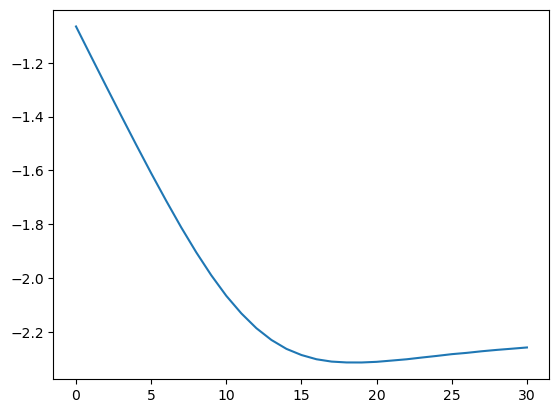

In [19]:
plt.plot(np.log10(np.sum((x_hist - x_cvxpy_test.detach().numpy())**2,axis = 1)))